# Siamese Network for MNIST

https://zhangruochi.com/Create-a-Siamese-Network-with-Triplet-Loss-in-Keras/2020/08/11/

In [1]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

from pca_plotter import PCAPlotter

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.4.1


## Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)

(60000, 28, 28)


In [3]:
# reshape(x_train, 28x28) => reshape(x_train, 784): change 2D array to 1D array
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2]))/255.
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2]))/255.
print(x_train.shape)

(60000, 784)


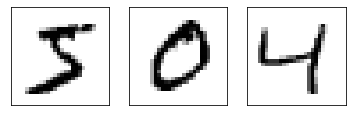

In [4]:
def plot_triplets(examples):
    plt.figure(figsize=(6, 2))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        plt.imshow(np.reshape(examples[i], (28, 28)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
plot_triplets([x_train[0], x_train[1], x_train[2]])

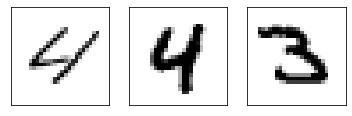

In [5]:
def create_batch(batch_size, x_dataset,y_dataset):
    x_anchors = np.zeros((batch_size, 784))
    x_positives = np.zeros((batch_size, 784))
    x_negatives = np.zeros((batch_size, 784))
    
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, x_dataset.shape[0] - 1)
        x_anchor = x_dataset[random_index]
        y = y_dataset[random_index]
        
        indices_for_pos = np.squeeze(np.where(y_dataset == y))
        indices_for_neg = np.squeeze(np.where(y_dataset != y))
        
        x_positive = x_dataset[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = x_dataset[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

examples = create_batch(1,x_train,y_train)
plot_triplets(examples)

In [6]:
emb_size = 64

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(emb_size, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


2023-01-10 23:44:55.551041: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
example = np.expand_dims(x_train[0], axis=0)
example_emb = embedding_model.predict(example)[0]

print(example_emb)

2023-01-10 23:44:55.725777: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


[0.49458686 0.53864765 0.55814576 0.5689673  0.44333255 0.46078247
 0.54198664 0.4369445  0.61028177 0.56876904 0.59446657 0.49970952
 0.7097815  0.43753934 0.4684785  0.4593178  0.6201339  0.3281476
 0.46788204 0.5220664  0.57464385 0.5177847  0.55699205 0.53898627
 0.5518343  0.38351756 0.326236   0.50265783 0.5432237  0.57782745
 0.49563423 0.5128563  0.34998795 0.51163536 0.63379765 0.57683825
 0.5785676  0.5196604  0.42211816 0.57628226 0.48032248 0.566378
 0.541324   0.52968746 0.45834097 0.55774415 0.55112886 0.3135029
 0.57100075 0.61514163 0.3962716  0.29896975 0.42681056 0.46161714
 0.34317416 0.5898048  0.48561892 0.43278396 0.55799526 0.5715003
 0.48791388 0.63953185 0.52157056 0.50750786]


## Siamese Network

In [8]:
input_anchor = tf.keras.layers.Input(shape=(784,))
input_positive = tf.keras.layers.Input(shape=(784,))
input_negative = tf.keras.layers.Input(shape=(784,))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           54400       input_1[0][0]                    
                                                                 input_2[0][0]                

### triplet loss

In [9]:
alpha = 0.2

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)


### data generator

In [10]:
def data_generator(batch_size,x_dataset,y_dataset):
    while True:
        x = create_batch(batch_size,x_dataset,y_dataset)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

## model training

/Users/muhammadaasem/dev-python/siamese-network/pca_plotter.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpc5vdi6fz.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpc5vdi6fz.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


KeyboardInterrupt: 

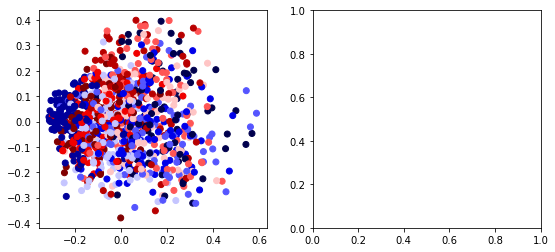

In [11]:
batch_size = 2048
epochs = 10
steps_per_epoch = int(x_train.shape[0]/batch_size)

net.compile(loss=triplet_loss, optimizer='adam')

_ = net.fit(
    data_generator(batch_size, x_train,y_train),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, verbose=False,
    callbacks=[
        PCAPlotter(
            plt, embedding_model,
            x_test[:1000], y_test[:1000]
        )]
)

In [ ]:
net.evaluate(data_generator(batch_size,x_test,y_test) )